### **CUDA Libraries**

In [1]:
!nvidia-smi

Thu May 25 16:41:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 21.42 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.8 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496

In [3]:
import cudf
cudf.__version__

'23.04.01'

In [4]:
import cuml
cuml.__version__

'23.04.01'

In [5]:
import cugraph
cugraph.__version__

'23.04.01'

In [6]:
!pip install gpustat==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 9.1 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19867 sha256=2d1f107879200346465faf2d958f47ccf81e5ae37c4736132fc6969640d97720
  Stored in directory: /root/.cache/pip/wheels/d2/48/27/33e31726d2001b997a11c23a7c76f7a48d8d96851f14ef0cd2
Successfully built gpustat


### **Import Libraries**

In [8]:
import os
import numpy as np 
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy


import tensorflow as tf
import time

In [9]:
import time
import psutil
import cProfile
from gpustat import GPUStatCollection
import cudf
import cuml

### **Get the Dataset**

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
# Set the path for the dataset
directory = '/content/drive/MyDrive/CK+48'

# Get the list of directories in the dataset directory
dir_list = os.listdir(directory)

# Initialize lists to store image data, labels, and emotions
image_data_list = []
labels = []
emotions = []
l = 0

# Iterate over each directory in the dataset
for data_dir in dir_list:
    # Get the list of images in the current directory
    data_list = os.listdir(directory + '/' + data_dir)
    
    # Iterate over each image in the directory
    for img in data_list:
        # Read and resize the image
        input_img = cv2.imread(directory + '/' + data_dir + '/' + img)
        input_img = cv2.resize(input_img, (48, 48))
        
        # Append the image data and label to the respective lists
        image_data_list.append(input_img)
        labels.append(l)
    
    # Append the emotion label to the emotions list
    emotions.append(data_dir)
    l = l + 1
 

# Normalize the image data
img_data = np.array(image_data_list)
img_data = img_data / 255

# Print the shape of the image data
print(img_data.shape)

(981, 48, 48, 3)


### **Split the data**

In [13]:
# Perform a stratified train-test split
train_images, test_images, train_labels, test_labels = train_test_split(
    img_data, labels, test_size=0.2, stratify=labels, random_state=42
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Print the shape of the train and test datasets
print("Train dataset shape:", train_dataset.reduce(0, lambda x, _: x + 1).numpy())
print("Test dataset shape:", test_dataset.reduce(0, lambda x, _: x + 1).numpy())

Train dataset shape: 784
Test dataset shape: 197


### **Create the model**

In [15]:
from keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [16]:
# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

In [18]:
num_classes = 7

In [19]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x) # Dropout layer to reduce overfitting
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass classification
transfer_model = keras.Model(inputs=vgg_model.input, outputs=x)

In [20]:
# Compile the model
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### **Train the model**

In [21]:
# Convert train_labels to a NumPy array
train_labels = np.array(train_labels)

# Verify the shapes of train_images and train_labels
print(train_images.shape)
print(train_labels.shape)

(784, 48, 48, 3)
(784,)


In [ ]:
# # Start the timer
# start_time = time.time()

# # Continue with model fitting
# history = transfer_model.fit(train_images, train_labels, epochs=40, batch_size=32)

# # Calculate the total execution time
# end_time = time.time()
# execution_time = end_time - start_time
# print("Total execution time: {:.2f} seconds".format(execution_time))

In [ ]:
import subprocess
import json

def print_gpu_usage():
    # Run 'gpustat' command and retrieve GPU statistics
    cmd = 'gpustat --json'
    result = subprocess.check_output(cmd.split()).decode('utf-8').strip()
    gpu_stats = json.loads(result)['gpus']
    
    gpu_usage = []
    for i, gpu_stat in enumerate(gpu_stats):
        utilization = gpu_stat['utilization.gpu']
        gpu_usage.append(utilization)
        print(f"GPU {i} - Utilization: {utilization}%")
    return gpu_usage

In [40]:
start = time.time()
memory_before = psutil.virtual_memory().used
print("GPU usage before training:")
gpu_usage_before = print_gpu_usage()

# Continue with model fitting
gpu_usage_during = []
for epoch in range(20):
    history = transfer_model.fit(train_images, train_labels, epochs=1, batch_size=64, verbose=0)
    print(f"Epoch {epoch+1} completed")
    print("GPU usage during training:")
    gpu_usage_epoch = print_gpu_usage()
    gpu_usage_during.append(gpu_usage_epoch)
    print()

print("GPU usage after training:")
gpu_usage_after = print_gpu_usage()
print()

memory_after = psutil.virtual_memory().used
print(f"Memory used for training: {(memory_after - memory_before)/1024:.2f} KB\n")
end = time.time()
print(f"Execution time of the training: {end-start:.2f} seconds")


GPU usage before training:
GPU 0 - Utilization: 0%
Epoch 1 completed
GPU usage during training:
GPU 0 - Utilization: 44%

Epoch 2 completed
GPU usage during training:
GPU 0 - Utilization: 52%

Epoch 3 completed
GPU usage during training:
GPU 0 - Utilization: 47%

Epoch 4 completed
GPU usage during training:
GPU 0 - Utilization: 62%

Epoch 5 completed
GPU usage during training:
GPU 0 - Utilization: 59%

Epoch 6 completed
GPU usage during training:
GPU 0 - Utilization: 77%

Epoch 7 completed
GPU usage during training:
GPU 0 - Utilization: 70%

Epoch 8 completed
GPU usage during training:
GPU 0 - Utilization: 60%

Epoch 9 completed
GPU usage during training:
GPU 0 - Utilization: 75%

Epoch 10 completed
GPU usage during training:
GPU 0 - Utilization: 40%

Epoch 11 completed
GPU usage during training:
GPU 0 - Utilization: 40%

Epoch 12 completed
GPU usage during training:
GPU 0 - Utilization: 35%

Epoch 13 completed
GPU usage during training:
GPU 0 - Utilization: 31%

Epoch 14 completed
GPU

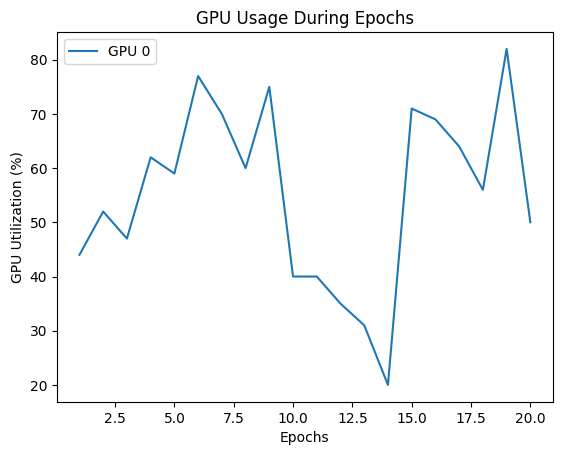

In [42]:
import matplotlib.pyplot as plt

# Plot GPU usage during epochs
epochs = range(1, len(gpu_usage_during) + 1)
for gpu_index, gpu_usage in enumerate(zip(*gpu_usage_during)):
    plt.plot(epochs, gpu_usage, label=f"GPU {gpu_index}")

plt.title("GPU Usage During Epochs")
plt.xlabel("Epochs")
plt.ylabel("GPU Utilization (%)")
plt.legend()
plt.show()

In [ ]:
# predicted_labels = transfer_model.predict(test_images)
# predicted_classes = np.argmax(predicted_labels, axis=-1)

# accuracy = np.sum(predicted_classes == test_labels) / len(test_labels)
# print("Accuracy on test set: {:.2f}%".format(accuracy * 100))
